In [80]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [81]:
torch.__version__

'1.13.1+cu116'

In [82]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device = {device}")

Device = cuda


In [83]:
# Data using wx+b formula 
weights= 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weights * X + bias

X[:5], y[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))

In [84]:
#Split Data train, test
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_test), len(y_test), len(X_train), len(y_train)

(10, 10, 40, 40)

In [85]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

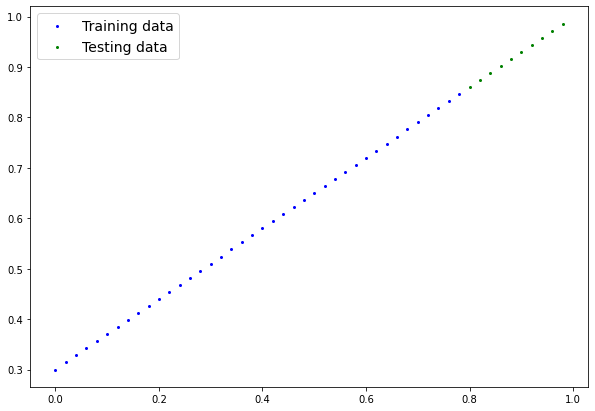

In [86]:
plot_predictions(X_train, y_train, X_test, y_test)

In [87]:
#Building linear Model

class RegLinearModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Linear(in_features=1, out_features=1)

  def forward(self,x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)  

torch.manual_seed(42)
model_01 = RegLinearModel()
model_01, model_01.state_dict()

(RegLinearModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [88]:
#check device by default CPU
#next(model_01.parameters()).device
#convert it to gpu if exists
model_01.to(device)
next(model_01.parameters()).device

device(type='cuda', index=0)

In [89]:
#Setup loss function and optimizer
loss_fn = nn.L1Loss()

#Setup optmizer
optimizer = torch.optim.SGD(params=model_01.parameters(), lr=0.01)

In [90]:
#Start training
torch.manual_seed(42)
epochs = 200

#put everything on gpu if avaliable
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  #evertime we train we want it to be in train mode
  model_01.train()

  #forward pass
  y_pred = model_01(X_train)

  #calculate loss 
  loss = loss_fn(y_pred, y_train)

  #optimize zero grad
  optimizer.zero_grad()

  #perform backpropgation
  loss.backward()

  #optimizer step (better way to step .i.e bring line closer or push line)
  optimizer.step()

  #Testing current model
  model_01.eval() #remove all unwanted things from model which are used during training

  with torch.inference_mode():
    #predict current model with test data
    test_pred = model_01(X_test)

    #calculate loss function
    test_loss = loss_fn(test_pred, y_test)

  if epoch %100 == 0:
    print(f"Epoch: {epoch} | loss: {loss} | test_loss: {test_loss}")


Epoch: 0 | loss: 0.5551779866218567 | test_loss: 0.5739762187004089
Epoch: 100 | loss: 0.006215683650225401 | test_loss: 0.014086711220443249


In [91]:
model_01.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

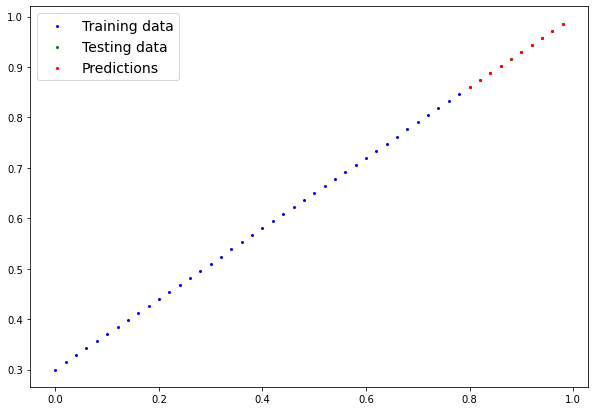

In [92]:
#Start Making Prediction 

#turn into eval as everytime we make prediction or inference we should switch our model to eval
model_01.eval()

with torch.inference_mode():
  y_pred = model_01(X_test)

plot_predictions(predictions=y_pred.cpu()) #.cpu because numpy is uses cpu and out y_pred is on gpu

In [93]:
#Save and Load the model

from pathlib import Path

#create model dir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#create model save path
MODEL_NAME = "model_01.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#save model
torch.save(obj=model_01.state_dict(), f=MODEL_SAVE_PATH)
print(f"Save Model to {MODEL_SAVE_PATH}")

Save Model to models/model_01.pth


In [94]:
#load model

#create new instance of model
loaded_model = RegLinearModel()

#load saved dict into model
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

#save model to device
loaded_model.to(device)


RegLinearModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [97]:
#lets start predecting
loaded_model.eval()

with torch.inference_mode():
  loaded_y_pred = loaded_model(X_test)

y_pred == loaded_y_pred


tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')